# STRING enrichment analysis

In this notebook, we test for enrichment of overlap between detected mutual exclusivities and function interactions according to STRING.

In [1]:
import sys
sys.path.append("../lib")

In [2]:
import numpy

In [3]:
import sqlite3

In [4]:
import networkx

In [5]:
import nbsupport.io
import nbsupport.stringdb
import nbsupport.util

In [6]:
DATA_DIR = "../data"

## Download STRING data

The code below downloads STRING data files and creates a database containing the functional interaction network.

In [7]:
import urllib

In [8]:
protein_links_url = "http://string.embl.de/newstring_download/protein.links.detailed.v10/9606.protein.links.detailed.v10.txt.gz"
protein_aliases_url = "http://string.embl.de/newstring_download/protein.aliases.v10/9606.protein.aliases.v10.txt.gz"

In [9]:
filename, respose = urllib.urlretrieve(protein_links_url, "../data/downloads/9606.protein.links.detailed.v10.txt.gz")
filename, respose = urllib.urlretrieve(protein_aliases_url, "../data/downloads/9606.protein.aliases.v10.txt.gz")

In [10]:
!mkdir {DATA_DIR}/string

In [11]:
nbsupport.stringdb.create_string_db(
    "../data/string/string.sqlite",
    "../data/downloads/9606.protein.links.detailed.v10.txt.gz",
    "../data/downloads/9606.protein.aliases.v10.txt.gz")

## Enrichment analysis

In [12]:
dataFile = "../data/tcga/tcga-pancan12.h5"

In [13]:
result_mutex = nbsupport.io.load_pairwise_result(dataFile, "/results/mutex")

In [14]:
sigPairs = result_mutex.significant_pairs(0.01)

In [15]:
genes = numpy.char.partition(numpy.asarray(result_mutex.qvalues.index).astype(str), "_")[:, 0]

The `mutexes` graph contains nodes for all genes used in the mutual exclusivity analysis, and edges connecting genes if their alterations are mutually exclusive.

In [16]:
mutexes = networkx.Graph([
        (pair.gene1.split("_")[0], pair.gene2.split("_")[0])
        for i, pair in sigPairs.iterrows()])
mutexes.add_nodes_from(numpy.unique(genes))

The `string` graph contains the STRING functional interaction network based on interactions with a combined score greater than 800.

In [17]:
db = sqlite3.connect("../data/string/string.sqlite")
cursor = db.execute(
    """
    SELECT n1.protein_name, n2.protein_name
    FROM protein_names AS n1,
         protein_names AS n2,
         protein_links AS ppi
    WHERE n1.protein_id = ppi.protein_id_a
      AND n2.protein_id = protein_id_b 
      AND n1.source = "BioMart_HUGO" 
      AND n2.source = "BioMart_HUGO" 
      AND ppi.combined_score > 800
    """)

string = networkx.Graph()
string.add_edges_from(cursor)

The `stringDeg2` graph connects genes if they have a direct functional interaction, or if they share a common interactor.

In [18]:
stringDeg2 = string.copy()

for node in string.nodes_iter():
    for neighbour in string.neighbors_iter(node):
        for neighbour2 in string.neighbors_iter(neighbour):
            stringDeg2.add_edge(node, neighbour2)

We can now determine the overlap of the mutually exclusive gene pairs with the graphs `string` and `stringDeg2`.

In [19]:
for gene1, gene2 in mutexes.edges_iter():
    if string.has_edge(gene1, gene2):
        print gene1, gene2

PIK3CA TP53
PIK3CA PTEN
PIK3CA PIK3R1
PIK3CA MYC
PIK3CG KRAS
CCND1 BCL2L1
CCND1 CCNE1
CCND1 MYC
PTEN ERBB2
PTEN TP53
CTCF TP53
CTCF SIN3A
NF1 KRAS
EGFR KRAS
CTNNB1 TP53
CTNNB1 APC
HUWE1 TP53
MDM2 MDM4
CDH1 TP53
CDKN2A RB1
ARID1A TP53
ATM TP53
MTOR TP53
MTOR KRAS
EP300 TP53
TP53 KRAS
TP53 CASP8
TP53 TP53BP1
MLLT4 KRAS
KRAS NRAS
KRAS BRAF


In [20]:
numOverlap = sum(string.has_edge(gene1, gene2) for gene1, gene2 in mutexes.edges_iter())

In [21]:
numOverlapDeg2 = sum(stringDeg2.has_edge(gene1, gene2) for gene1, gene2 in mutexes.edges_iter())

In [22]:
mutexes.number_of_edges(), numOverlap, numOverlapDeg2

(181, 31, 121)

### Enrichment for direct functional interactions

In [23]:
def permutedGraph(g):
    mapping = dict(zip(g, numpy.random.permutation(g)))
    return networkx.relabel_nodes(g, mapping)

In [24]:
nbsupport.util.set_random_seed()

We estimate a null distribution for the observed overlap of mutual exclusivities and functional interactions. To do so, we permute the labels of the `mutex` graph, and compute the overlap of this permuted graph.

In [25]:
nullDist = numpy.array([
        sum(string.has_edge(gene1, gene2) for gene1, gene2 in permutedGraph(mutexes).edges_iter())
        for i in xrange(10000)])

In [26]:
numOverlap, nullDist.mean()

(31, 4.9432999999999998)

The proportion of permutations with an overlap at least as high as the observed overlap gives us a $P$-value for the enrichment.

In [27]:
numpy.mean(nullDist >= numOverlap)

0.0

In [28]:
numpy.mean(numpy.append(nullDist, numOverlap) >= numOverlap)

9.9990000999900015e-05

In [29]:
%matplotlib inline

In [30]:
import matplotlib.pyplot as plt

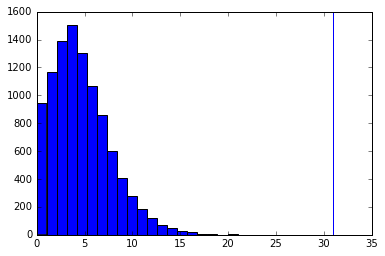

In [31]:
plt.hist(nullDist, 20)
plt.axvline(numOverlap)

### Enrichment for indirect functional interactions

We estimate a null distribution in the same way as for the direct interactions, but this time using `stringDeg2` to compute the overlap.

In [32]:
nullDist2 = numpy.array([
        sum(stringDeg2.has_edge(gene1, gene2) for gene1, gene2 in permutedGraph(mutexes).edges_iter())
        for i in xrange(10000)])

In [33]:
numOverlapDeg2, nullDist2.mean()

(121, 79.754099999999994)

In [34]:
numpy.mean(numpy.append(nullDist2, numOverlapDeg2) >= numOverlapDeg2)

0.0026997300269973002

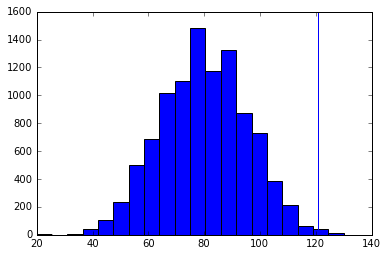

In [35]:
plt.hist(nullDist2, 20)
plt.axvline(numOverlapDeg2)